<a href="https://colab.research.google.com/github/chape8/Signal-Processing-III/blob/main/miniProyecto1_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

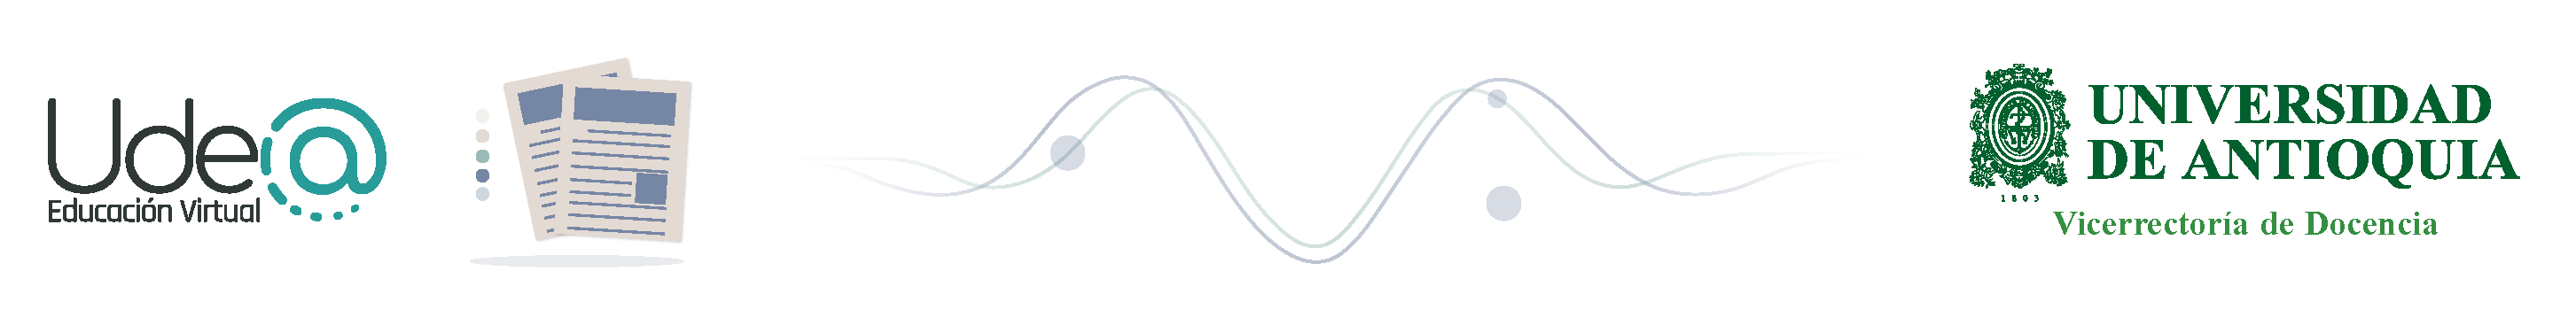

# Affective Computing Analysis

**Tratamiento de Señales III**

*Prof. Hernán Felipe García Arias*

*Facultad de Ingeniería*

*Universidad de Antioquia*

*2022-1*



>This project aims to characterize physiological patterns on multivariate signals such as EEG, ECG, EOG, and EMG to capture relevant patterns that define an emotional process.









## Cargar bases de datos de computación afectiva


La base de datos [DEAP](http://www.eecs.qmul.ac.uk/mmv/datasets/deap/index.html) es un conjunto de datos multimodal para el análisis de los estados afectivos humanos. El electroencefalograma (EEG) y las señales fisiológicas periféricas de 32 participantes se registraron mientras cada uno miraba 40 extractos de videos musicales de un minuto de duración. Los participantes calificaron cada video en términos de niveles de excitación (arousal), valencia, me gusta / no me gusta, dominio y familiaridad. Para 22 de los 32 participantes, también se grabó un video de cara frontal. Se utilizó un método novedoso para la selección de estímulos, utilizando la recuperación por etiquetas afectivas del sitio web last.fm, detección de videos destacados y una herramienta de evaluación en línea.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np

#ruta = '/content/drive/MyDrive/Colab_Notebooks/Miniproyecto1/'
ruta = '/content/drive/MyDrive/Señales3/ArchivosMiniProy1/'
fileName = 'affetiveDB_1.mat'
db = sio.loadmat(ruta+fileName)


In [3]:
X = db['data']
X.shape

(40, 40, 6528)

### Dataset description

La base de datos se le removieron los 3 segundos iniciales de acondicionamiento. El arreglo X contiene todas las respuestas emocionales de las señales biológicas, para 40 videos diferentes. El arreglo se organiza de la forma

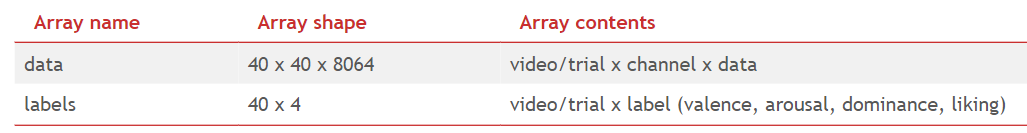

La siguiente tabla muestra el diseño de canales y el preprocesamiento realizado:

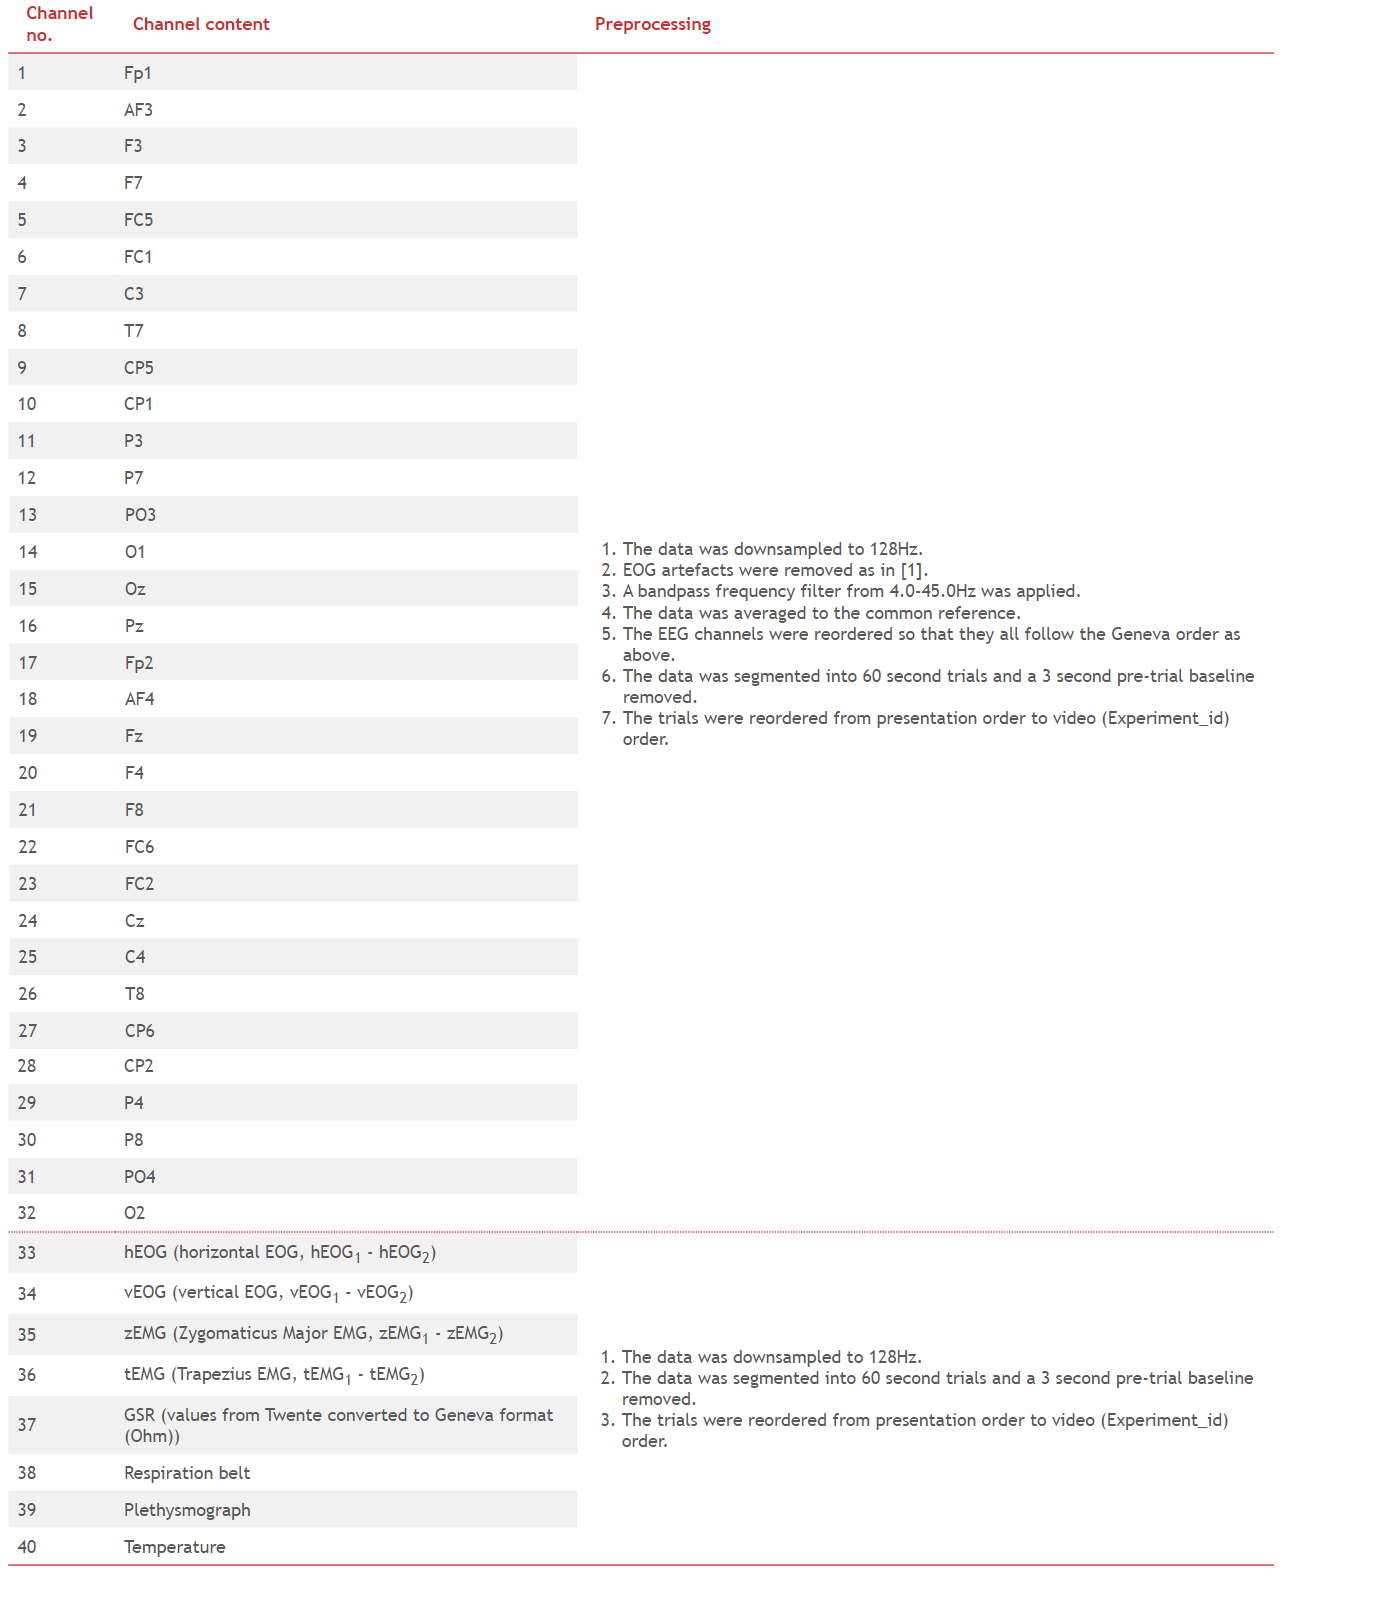

## Siglas señales fisiológicas

EEG: señales electroencefalográficas 
Generalmente son 32 canales 

EOG: electrooculograma (2 señales) movimientos verticales y horizontales

EMG: electromiogramas (2 señales) para los movimientos de los músculos (en la base de datos se capturó la señal del rostro).

Respiration belt:  banda que mide la frecuencia respiratoria

Temperatura: Mide la temperatura de la piel

Plethimograph:  Un pletismógrafo es un instrumento para medir cambios de volumen dentro de un órgano o de todo el cuerpo (generalmente como resultado de fluctuaciones en la cantidad de sangre o aire que contiene). Nos sirve como medida de el rítmo cardiaco (HR)

## Gráfica de una señal emocional

Por ejemplo si queremos obtener la señal de **respiration belt (respiración)** de la base de datos para el video número 15 (i.e., por elegir alguno), debe acceder a los datos mediante:

In [4]:
from scipy.signal import butter, lfilter, freqz, sosfilt
from scipy import signal
from scipy.fft import fft
import scipy.signal
from scipy.signal import find_peaks
import pandas as pd
import seaborn as sns

# Filtros

In [5]:


def butter_bandpass(lowcut, highcut, fs, order):
    #nyq = 0.5 * fs
    #low = lowcut / nyq
    #high = highcut / nyq
    sos_fil = butter(order, [lowcut, highcut], btype='band',output='sos',fs=128,analog=False)
    return sos_fil

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos,data)
    return y

def butter_lowpass(cut, fs, order):
    #nyq = 0.5 * fs
    #low = lowcut / nyq
    #high = highcut / nyq
    sos_fil = butter(order, cut, btype='low',output='sos',fs=128,analog=False)
    return sos_fil

def butter_lowpass_filter(data, cut, fs, order):
    sos = butter_lowpass(cut, fs, order=order)
    w, h = signal.sosfreqz(sos)
    '''plt.semilogx(w, 20 * np.log10(abs(h)))
    plt.axvline(cut, color='green') # cutoff frequency
    plt.show()'''
    y = sosfilt(sos,data)
    return y

In [6]:
def getFeatures(trial, X):
  caracteristicas = []
  caracteristicas_GSR = GSR(trial, X) 
  caracteristicas = caracteristicas + caracteristicas_GSR
  caracteristicas_BVP = BVP(trial, X)
  caracteristicas = caracteristicas + caracteristicas_BVP
  caracteristicas_RP = RP(trial, X)
  caracteristicas = caracteristicas + caracteristicas_RP
  caracteristicas_ST = ST(trial, X)
  caracteristicas = caracteristicas + caracteristicas_ST
  caracteristicas_EOG = EOG(trial, X)
  caracteristicas = caracteristicas + caracteristicas_EOG
  caracteristicas_EEG = EEG(trial, X)
  caracteristicas = caracteristicas + caracteristicas_EEG
  return caracteristicas

# GSR

- Average Skin Resistance
- Average Rising Time
- 10 Spectral power in the [0-2.4]Hz bands

In [7]:
def GSR(trial, X):
  channel = 37
  skin_resistance = X[trial-1,channel-1,:]
  caracteristicas = []
  #Calculating average skin resistance

  average_skin_resistance = round(np.average(skin_resistance),4)
  #print("ASR: "+str(average_skin_resistance))
  caracteristicas.append(average_skin_resistance)

  #Calculating average rising time

  contador = 0
  time = []
  for i in range(0,len(skin_resistance)-1):
      if skin_resistance[i+1] >= skin_resistance[i]:
          contador += 1
      else:
          if contador > 32:
            time.append(contador/128)
          contador=0
  if contador > 32: #This 'if' is useful when the signal ends still rising 
    time.append(contador/128)

  #print("Rising times: " +str(time))
  average_rising_time = round(np.average(time),4)
  #print("ART: "+str(average_rising_time)+" secs")

  caracteristicas.append(average_rising_time)

  #Calculating 10 spectral power in the [0-2.4]Hz Bands

  # 1. Filtering the signal in the band requeried

  filtered_skin_resistance = butter_lowpass_filter(skin_resistance, cut=2.4, fs=128, order=8)

  ts = len(filtered_skin_resistance)/128.
  time = np.linspace(0,ts,len(filtered_skin_resistance))

  # 2. Calculating FFT
 
  yf = fft(filtered_skin_resistance)

  yf_aux = 2.0/len(filtered_skin_resistance) * np.abs(yf[1:len(filtered_skin_resistance)//2])


  potencias = []
  aux = yf_aux
  #print(aux)
  for i in range(0,10):
    potencias.append(np.max(aux))
    caracteristicas.append(np.max(aux))
    result = np.where(aux == np.max(aux))
    aux=np.delete(aux,result[0][0])
  #print("10 spectral powers: "+str(potencias))

  return caracteristicas

## Blood Volume Preasure

-Average and standard deviation of HR.

-Spectral power in the bands ([0.1-0.2]Hz, [0.2-0.3]Hz, [0.3-0.4]Hz)

In [8]:
def BVP(trial, X):
  caracteristicas=[]
  channel = 39 # canal de la señal fisiológica
  
  BloodVol = X[trial,channel-1,:]
  #print(BloodVol.shape)
  mean = np.nanmean(BloodVol)
  caracteristicas.append(mean)
  std = np.nanstd(BloodVol)
  caracteristicas.append(std)

  fs=128.0
  #lowcut = 0.2
  #highcut = 0.3

  lowcut = [0.1,0.2,0.3]
  highcut = [0.2,0.3,0.4]
  for lowcut, highcut in zip(lowcut, highcut):
    
    respiration = X[trial,channel-1,:]
    ts = len(respiration)/128.
    time = np.linspace(0,ts,len(respiration))

    y = butter_bandpass_filter(respiration, lowcut, highcut, fs, order=8)

    f, Pxx_den = signal.welch(y, 128., nperseg=1024)
    #plt.semilogy(f, Pxx_den)

    maximo=max(Pxx_den)
    #print(maximo)

    if lowcut==0.1:
      caracteristicas.append(maximo)      #No se como agregar la tupla con el valor maximo de la DEP y la frecuencia a la que está,sale errores
    elif lowcut==0.2:
      caracteristicas.append(maximo)
    elif lowcut==0.3:
      caracteristicas.append(maximo)
    
  return caracteristicas

Para sacar la potencia espectral en cada una de las bandas primero se procede haciendo un filtrado de la señal para luego pasarle la salida del filtro a un metodo de la libreria de scipy llamado welch ( estima la densidad espectral de potencia dividiendo los datos en segmentos y promediando los periodogramas calculados en cada segmento)


#Respiration Pattern
Average respiration signal

Breathing rate
 
Average peak to peak time


In [9]:
def RP(trial, X):
  caracteristicas=[]
  channel = 38 

  respiration = X[trial,channel-1,:]
  respiration = butter_bandpass_filter(respiration, 0.05, 1.5, 128., order=8) #Se filtra la señal para lograr un suavizado y lograr un mejor resultado
  mean = np.nanmean(respiration)

  des=np.nanstd(respiration)
  peaks2, _ = find_peaks(respiration, prominence=des)
  #print(len(peaks2))

  Num_resp=len(peaks2)
  Num_resp=(Num_resp*60)//51  #Esta regla de 3 sugeridad por el profesor puesto que la señal es de 51 segundo y breathing_rate se mide por minuto


  diff_x1 = np.diff(peaks2)
  time_peak=(sum(diff_x1)/len(diff_x1))/128.


  #plt.plot(peaks2,respiration[peaks2], "xr")
  caracteristicas.append(mean)
  caracteristicas.append(Num_resp)
  caracteristicas.append(time_peak)

  return caracteristicas

 **time_peak** :  Utilizamos la funcion find_peaks() que se encuentra dentro de la libreria de scipy para encontrar el numero de picos mas marcados que representan una respiracion de la persona (a este numero de picos le hacemos una regla de 3 pues la señal dura 51 segundo y breathing_rate se mide por minuto). Con np.diff calculamos la diferencia entre picos consecutivos de la señal, sumamos y promediamos entre el total de picos y asi encontramos la caracteristica  **time_peak**.

# Skin temperature

- Average Skin Temperature
- Average of its derivative
- Spectral power in the bands ([0-0.1]Hz, [0.1-0.2]Hz)

In [10]:
def ST(trial, X):
  caracteristicas=[]
  channel = 40
  skin_temperature = X[trial-1,channel-1,:]

  ts = len(skin_temperature)/128.
  time = np.linspace(0,ts,len(skin_temperature))

  #Calculating average skin temperature

  average_skin_temperature = np.average(skin_temperature)
  caracteristicas.append(average_skin_temperature)
  #print("AST: "+str(average_skin_temperature))

  #Calculating average of its derivative

  derivative_skin_temperature = np.gradient(skin_temperature)/np.gradient(time)
  average_derivative_ST = np.average(derivative_skin_temperature)
  caracteristicas.append(average_derivative_ST)

  #print("ADST: "+str(average_derivative_ST))


  #Calculating spectral power in the bands ([0-0.1]Hz,[0-0.2]Hz)

  # Band [0-0.1]

  filtered_skin_temperature = butter_lowpass_filter(data = skin_temperature, cut = 0.1, fs = 128 , order = 8)


  # 2. Calculating FFT

  yf = fft(filtered_skin_temperature)

  yf_aux = 2.0/len(filtered_skin_temperature) * np.abs(yf[1:len(filtered_skin_temperature)//2])

  fs = 128 # fs
  f, Pxx_ST = signal.welch(filtered_skin_temperature, fs, nperseg=64)

  maximo1 = max(Pxx_ST)
  caracteristicas.append(maximo1)
  # Band [0.1-0.2]

  filtered_skin_temperature = butter_bandpass_filter(data = skin_temperature, lowcut = 0.1, highcut = 0.2, fs = 128 , order = 8)

  # 2. Calculating FFT
  
  yf = fft(filtered_skin_temperature)

  yf_aux = 2.0/len(filtered_skin_temperature) * np.abs(yf[1:len(filtered_skin_temperature)//2])
 
  fs = 128 # fs
  f, Pxx_ST = signal.welch(filtered_skin_temperature, fs, nperseg=64)

  maximo2 = max(Pxx_ST)
  caracteristicas.append(maximo2)

  return caracteristicas

#EMG and EOG
-Eye blinking rate, mean and variance of the signal

In [11]:
def EOG(trial, X):
  caracteristicas=[]
  channel = 33 # canal de la señal fisiológica
 
  eye = X[trial,channel-1,:]
  '''#Se realiza un filtrado similar al punto anterior pues la señal aparecia muy ruidosa y se obtienen mejores resultados
  Los valores de las frecuencias de corte fueron dejadas de manera experimental y funcionaron'''
  eye = butter_bandpass_filter(eye, 0.05, 1.5, 128., order=8)
  des = np.nanstd(eye)
  picos, _ = find_peaks(eye, prominence=des)
  Num_resp=len(picos)
  Num_resp=(Num_resp*60)//51  #Esta regla de 3 sugeridad por el profesor puesto que la señal es de 51 segundo y breathing_rate se mide por minuto
  

  mean=np.nanmean(eye)
  var=np.nanvar(eye)

  caracteristicas.append(Num_resp)
  caracteristicas.append(mean)
  caracteristicas.append(var)

  return caracteristicas

# EEG
- theta (4 to 7Hz); alpha (8 to 12Hz); beta (13 to 30Hz) spectral power for each pair of electrodes 

In [12]:
def EEG(trial, X):
  channel_pairs = [[1,17],[3,20],[7,25],[11,29],[14,32]]
  #[Fp1,Fp2],[F3,F4],[C3,C4],[P3,P4],[O1,O2]

  caracteristicas = []
  bands = [[4,7],[8,12],[13,30]]
  #[theta, alpha, beta]
  
  fs = 128 # fs
  for j in range(0,len(bands)):

    for i in range(0,len(channel_pairs)):
      left_channel = X[trial-1,channel_pairs[i][0]-1,:]
      right_channel = X[trial-1,channel_pairs[i][1]-1,:]
      electrode_pair = left_channel - right_channel
      electrode_pair = butter_bandpass_filter(electrode_pair, bands[j][0], bands[j][1], 128., order=8)
      f, Pxx_electrode_pair = signal.welch(electrode_pair, fs, nperseg=64)
      potMax = np.max(Pxx_electrode_pair)
      caracteristicas.append(potMax)

  return caracteristicas

In [13]:
Matriz=[]
for i in range(0,40):
  carac = getFeatures(i, X)
  Matriz.append(carac)

print(np.shape(Matriz))


(40, 42)


## Etiquetas emocionales

Cada una de las realizaciones induce una emoción en los sujetos. Por lo tanto cada realización (de las 40) tiene sus correspondientes etiquetas de la forma:

Los modelos dimensionales sugieren que la emoción se entiende mejor cuando ocurre dentro de un espacio dimensional, más comúnmente un espacio bidimensional que abarca la valencia y la excitación. La valencia emocional describe el grado en que una emoción es positiva o negativa, mientras que la excitación se refiere a su intensidad, es decir, la fuerza del estado emocional asociado.


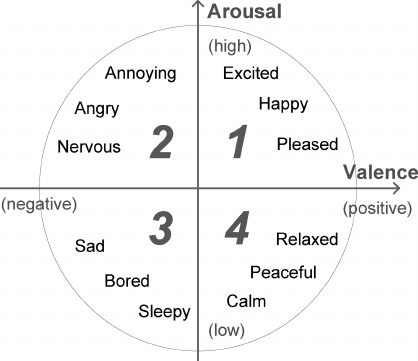

Las etiquetas están en el campo label:

labels	es una matriz de $40 \times 4$ en la cual se organiza de la forma	$video/trial \times label $ (valence, arousal, dominance, liking)

Valence	The valence rating (float between 1 and 9).
Arousal	The arousal rating (float between 1 and 9).
Dominance	The dominance rating (float between 1 and 9).
Liking	The liking rating (float between 1 and 9).


## EEG analysis

El análisis en el dominio de la frecuencia se realiza utilizando el algoritmo de Transformada Rápida de Fourier (FFT) (con una resolución de 0,125 Hz) para calcular la densidad de potencia absoluta (μV2 / Hz), la densidad de potencia relativa (%) y la frecuencia media (Hz) dentro de cada una de las subbandas. La potencia absoluta de una banda es la integral de todos los valores de potencia dentro de su rango de frecuencia. Los índices de potencia relativa (RP) para cada banda se encuentran expresando la potencia absoluta en cada banda de frecuencia como un porcentaje de la potencia absoluta (AP) sumada en las cuatro bandas de frecuencia. Para las medidas de asimetría de potencia inter-hemisférica (absoluta) para cada banda para siete sitios homólogos (AF3-AF4, F7-F8, F3-F4, FC5-FC6, T7-T8, P7-P8, O1-O2) y un conjunto adicional de diez pares de sitios de electrodos (AF3-F3, AF4-F4, F3-O1, F4-O2, FC5-P7, FC6-P8, P7-O1, P8-O2, T7-O1, T8-O2). Los índices de asimetría del hemisferio derecho (R) frente al hemisferio izquierdo (L) (R-L) se calcularon con la fórmula [(R-L) / (R + L)]. Para la simetría intra-hemisférica, las relaciones de valor anterior (A) (frontal) vs. posterior (P) (posterior) (A-P) para cada par de electrodos se derivaron con la fórmula [(A-P) / (A + P)]. Las variables de EEG de potencia absoluta y asimetría se pueden transformar logarítmicamente (log (χ)) y las variables de potencia relativa se pueden transformar mediante log [χ ÷ (1 - χ)] con el fin de normalizar la distribución de los datos [63-65].

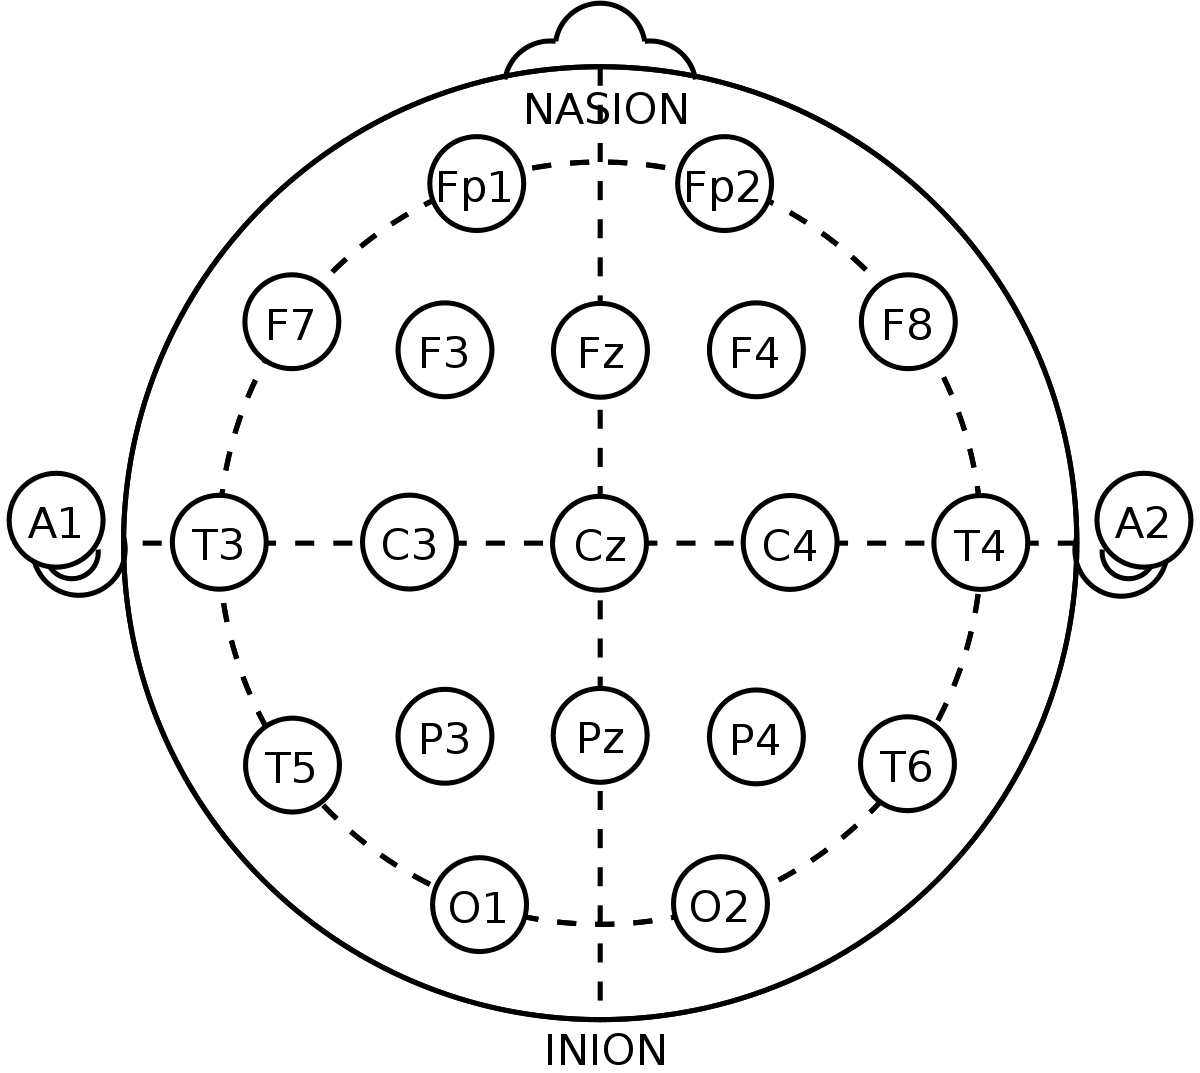

## Visualización de las etiquetas emocionales

Para esto, se realizará un agrupamiento de las etiqeutas de $arousal$, $valence$ en 3 grupos:

1. Emociones Negativas: arousal $[1-3]$ y valence $[1-3]$. 
2. Emociones Neutras: arousal $[4-6]$ y valence $[4-6]$.
3. Emociones Positivas: arousal $[7-9]$ y valence $[7-9]$. 

In [18]:
Neg = 'Neg'
Neu = 'Neu'
Pos = 'Pos'

labels = db['labels']


Valence = labels[:,0]
Arousal = labels[:,1]

emociones=[]

'''
for i in range(0,40):


  if(Valence[i]>=1 and Valence[i]<=5):
    if (Arousal[i]>5 and Arousal[i]<=9):
      emociones.append(Neg)
  elif(Valence[i]>5 and Valence[i]<=9):
    if (Arousal[i]>5 and Arousal[i]<=9):
      emociones.append(Pos)
  if(Valence[i]>=1):
    if (Arousal[i]>=1 and Arousal[i]<=5):
      emociones.append(Neu)


print(emociones)
'''
for i in range(0,40):

  if(Valence[i]>=1 and Valence[i]<=3.6):
    emociones.append(Neg)
  if(Valence[i]>3.6 and Valence[i]<=6.2):
    emociones.append(Neu)
  if(Valence[i]>6.2):
    emociones.append(Pos)




In [19]:
Nombres = ['GSR_ASR','GSR_ART','GSR_SP1','GSR_SP2','GSR_SP3','GSR_SP4','GSR_SP5','GST_SP6','GST_SP7','GST_SP8','GST_SP9','GST_SP10','BVP_AHR','BVP_STD'
,'BVP_SP1','BVP_SP2','BVP_SP3','RP_ARS','RP_BR','RP_AP2P','ST_AST','ST_AD','ST_SP1','ST_SP2','EMG_EBR','EMG_MEAN','EMG_VAR','EEG_SPT1','EEG_SPT2'
,'EEG_SPT3','EEG_SPT4','EEG_SPT5','EEG_SPA1','EEG_SPA2','EEG_SPA3','EEG_SPA4','EEG_SPA5','EEG_SPB1','EEG_SPB2','EEG_SPB3','EEG_SPB4','EEG_SPB5']

dataFrame = pd.DataFrame(data = Matriz, columns= Nombres)

dataFrame['emociones'] = emociones
SubData1 = dataFrame.iloc[:,30:40]
SubData1['emociones'] = emociones

SubData1

EEG_SPT4    EEG_SPT5  EEG_SPA1  EEG_SPA2  EEG_SPA3  EEG_SPA4   EEG_SPA5  \
0   2.223926   10.442598  1.035537  1.865161  5.184980  3.461216   5.041652   
1   5.245207   97.972547  1.991252  4.361935  7.807040  7.042410  11.376475   
2   3.246564   68.563268  1.756438  3.694577  6.448128  3.988058  13.472448   
3   2.131093   58.177634  2.597581  5.335904  4.490130  3.020488  15.374982   
4   7.958270  151.230628  1.907578  6.142650  5.798278  5.087005  25.914103   
5   3.092466   74.238551  1.894045  4.123910  3.896095  3.614934  12.999729   
6   3.744588   24.664843  2.146548  3.389828  5.144338  4.325678   9.845600   
7   2.498055   34.182642  1.768690  2.895643  4.206870  2.693486  11.025678   
8   3.013449   22.253433  1.171452  2.357371  5.321294  3.388625   5.438403   
9   2.872941   64.362813  1.707412  4.012138  5.584374  4.661680  13.543346   
10  3.671068   39.764321  1.281678  2.804834  7.129321  5.835401   6.305741   
11  4.097112   79.845464  2.648702  4.653199  5.506797  5.361625  11.215658   
12  4.598243  248.909282  2.337742  6.248544  5.716792  5.423960  25.914771   
13  2.387710   60.518468  1.723430  2.738108  6.054804  7.433029   9.363810   
14  4.311951  101.851343  2.244471  4.612809  7.792332  5.891236  14.574280   
15  2.805023  111.341312  1.930027  3.209124  4.058353  4.574443  11.197585   
16  4.227431  266.321641  1.447971  4.835779  4.010275  2.862487  14.667063   
17  3.512805   19.975525  1.964278  2.720558  5.432321  5.053306   8.105333   
18  3.421055   99.007869  2.403083  4.221895  4.459422  4.332791  12.179102   
19  3.880739   73.033768  2.106757  4.340865  5.303498  4.320496  14.856172   
20  3.545377   52.940045  1.837923  3.054564  5.873226  5.808287   6.816756   
21  3.707447   73.279104  2.361211  4.629022  5.402587  5.634675  16.009944   
22  4.530267  159.488284  1.874158  6.142572  4.193699  5.008203  19.581565   
23  3.291969   67.494061  1.425115  3.228899  5.066340  4.925969  10.251197   
24  4.324195   56.883529  1.128368  2.671405  6.891336  7.019048   7.952014   
25  4.003629  157.337625  1.124229  3.021470  4.703372  4.794944   8.369996   
26  2.531374   56.892900  1.397125  2.273559  4.077889  3.474779   5.760727   
27  2.846981   68.586908  1.671449  2.764844  4.813606  3.557609   8.240578   
28  1.765311    7.164299  1.388268  1.377201  4.239929  3.084478   2.858057   
29  2.359099   34.631986  1.347170  2.443402  4.471195  3.266643   6.100449   
30  2.291665   50.680999  1.802876  2.857250  4.145532  3.059361   8.816597   
31  3.598462  105.705330  2.412686  4.909190  4.929793  4.702753  15.510271   
32  4.778209  200.419574  2.484667  7.167882  6.604652  4.840419  26.214096   
33  3.283299  167.197793  1.987182  4.643214  4.956881  5.086032  14.737207   
34  4.238089   97.727854  1.552454  4.540832  5.368039  3.892777  16.632422   
35  4.636529  184.856780  1.907765  5.820064  4.946697  5.541347  21.914071   
36  2.219891   11.101403  1.062375  1.910872  5.659783  4.075671   5.211402   
37  3.178827   28.381979  1.562980  2.865720  5.336357  4.373795  11.086405   
38  2.765476   16.159444  1.512251  2.468072  5.461891  4.323230   7.454901   
39  3.192292   41.256791  1.489172  3.305632  5.577141  5.002395  10.984570   

    EEG_SPB1   EEG_SPB2  EEG_SPB3 emociones  
0   2.347163   1.275503  1.003328       Neg  
1   2.705221   1.546289  1.463202       Pos  
2   3.966875   7.282834  1.469042       Pos  
3   4.037560   3.302149  1.213788       Pos  
4   5.881958  11.364667  2.188542       Neu  
5   3.476684   2.377859  1.493458       Neu  
6   4.995091   2.106852  1.383918       Pos  
7   3.928179   1.561336  1.005914       Neg  
8   1.701443   0.935837  1.488231       Neu  
9   3.529477   2.317885  1.253263       Neu  
10  4.000219   1.813269  1.379476       Pos  
11  6.208382   1.810378  1.299229       Neu  
12  6.600925   1.856251  1.051998       Neu  
13  4.892052   1.348346  1.273580       Neu  
14  6.169200   1.771893  1.438325       Neg  
15  4.327970   2.006944  1.0

In [20]:

sns.set_style('darkgrid')
#fig, ax = plt.subplots()


unique = dataFrame["emociones"].unique()
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))

ax = sns.pairplot(data=dataFrame,  hue='emociones', palette=palette, corner = True)
#sns.pairplot(, hue="Tipo Mov",corner = True)
plt.tight_layout()
plt.figure()


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

#Analisis de datos

Lo primero que se puede observar del analisis de datos es que, dentro de la definición de los rangos que se realizo para catalogar el tipo de emoción que presentaron las personas durante las pruebas, la emoción que menos se presento es la catalogada como postiva, teniendo solo 7 videos en los cuales la persona presento esta reacción, 19 fueron neutrales y 14 fueron negativas. 

Los datos correspondientes a las emociones neutrales por lo general son los que presentan menos dispersión, osea se encuentran mas agrupados dentro de una región. Sin embargo hay casos como en la fila de la caracteristica EEG_SPB1 en la que se puede observar como las emociones positivas tiene menor dispersión que las otras 2 emociones y se agrupan hacia el centro (del eje y) en las graficas.

En algunas graficas, como por ejemplo en las filas de las caracteristicas EMG_VAR y EMG_MEAN se pueden observar valores atipicos que se encuentran alejados del promedio de todos los demas valores, esto puede representar una emoción más fuerte que la diferencia.

Por lo general, los valores de las emociones neutrales se encuentran mezclados tanto con los valores de las emociones postivias y negativas, porque estas emociones neutrales pueden tomar caracteristicas de las otras 2 emociones sin embargo con un menor impacto sobre el observador por lo tanto al categorizarlas entran en un rango neutral.

Para la fila de la caracteristicas BVP_SP1, los datos de las emociones postivias se encuentran menos dispersos, mientras que los valores de las emociones negativas tienden a tomar valores mas positivos en el eje Y, este es un ejemplo de una caaracteristicas que puede ser util para diferenciar entre las emociones positivas y negativas.


#Conclusiones

Al ser un dataset con señales mas complejas y una recolección de datos reales basados en estudios, la caracterización resulta mas dificil de analizar ya que no hay una diferenciación marcada que sea detectable a simple vista, se hace util la implementación de modelos de analisis basados en IA para lograr una mejor comprensión de que es lo que nos quiere decir los datos resultantes.
